In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
image_shape = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
IMG_SIZE = image_shape[0]
VAL_SPLIT = 0.2

In [3]:
class_folders = glob('flower_images/*')

paths = []
labels = []
for i in range(len(class_folders)):
    files = glob(f'{class_folders[i]}/*')
    labels.extend([ i for x in range(len(files)) ])
    paths.extend(files)

In [4]:
c = list(zip(paths, labels))
random.shuffle(c)

paths, labels = zip(*c)

lim = int(len(paths)*VAL_SPLIT)
labels = keras.utils.to_categorical(labels)

train_paths = list(paths[lim:])
train_labels = list(labels[lim:])

val_paths = list(paths[:lim])
val_labels = list(labels[:lim])

print(len(train_labels), len(train_paths))
print(len(val_labels), len(val_paths))

4000 4000
1000 1000


In [5]:
def get_data(image, label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE),)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, tf.cast(label, tf.float32)


def tf_dataset(images, labels):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.map(get_data)
    return dataset


train_data = tf_dataset(train_paths, train_labels)
val_data = tf_dataset(val_paths, val_labels)

val_ds = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

(224, 224, 3) (5,)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
flower_images/Lilly


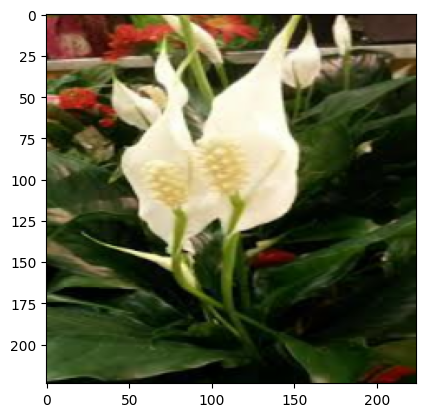

In [6]:
for x, y in train_data:
    print(x.shape, y.shape)
    plt.imshow(x)
    print(y)
    print(class_folders[np.argmax(y)])
    break

In [7]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

In [8]:
train_ds_one = (train_data.map(lambda x, y: (x, y)))
train_ds_two = (train_data.map(lambda x, y: (x, y)))

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


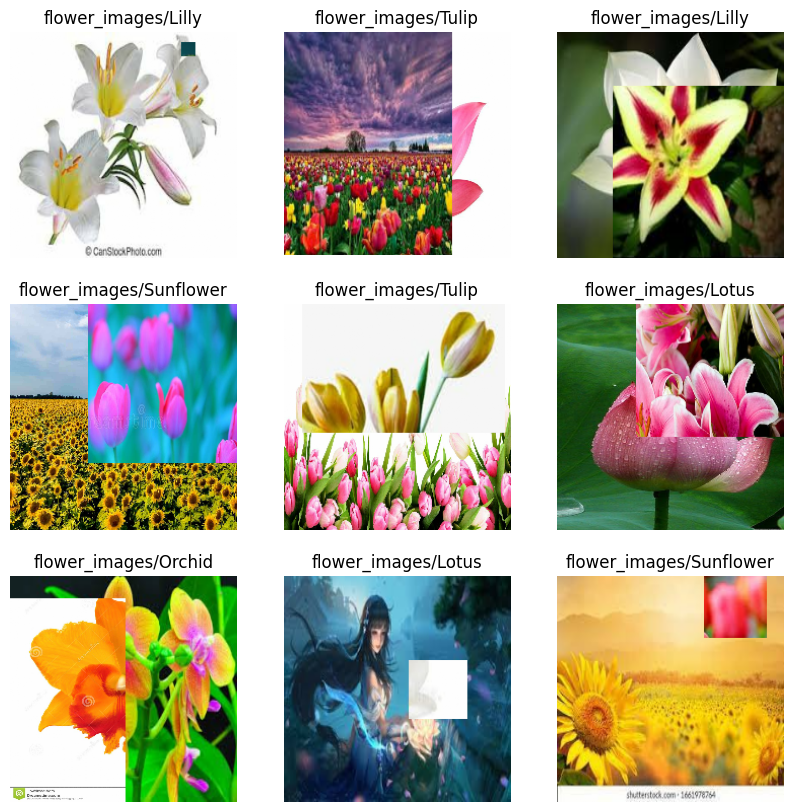

In [9]:
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_folders[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [10]:
data_augmentation = keras.Sequential([
    # keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [11]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [12]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[1][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 512)  2048       ['activation[1][0]']         

In [14]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-256-8-{epoch}.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [15]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_ds_cmu, epochs=10, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=callbacks, verbose='auto')

Epoch 1/10
400/400 [==============================] - 182s 386ms/step - loss: 1.5221 - accuracy: 0.3570 - val_loss: 1.6538 - val_accuracy: 0.3110 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - 158s 390ms/step - loss: 1.3745 - accuracy: 0.4465 - val_loss: 1.6227 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - 161s 396ms/step - loss: 1.3099 - accuracy: 0.4945 - val_loss: 1.1468 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - 156s 384ms/step - loss: 1.2612 - accuracy: 0.5195 - val_loss: 1.9609 - val_accuracy: 0.4690 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - 156s 385ms/step - loss: 1.2303 - accuracy: 0.5518 - val_loss: 1.1680 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - 157s 386ms/step - loss: 1.2005 - accuracy: 0.5602 - val_loss: 1.0948 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 7/10
400/400 [==========================

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'loss')]

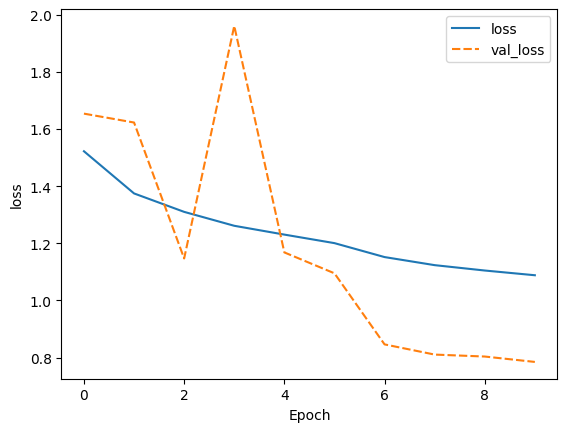

In [16]:
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
ax.set(xlabel='Epoch', ylabel='loss')

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'accuracy'), (0.0, 1.0)]

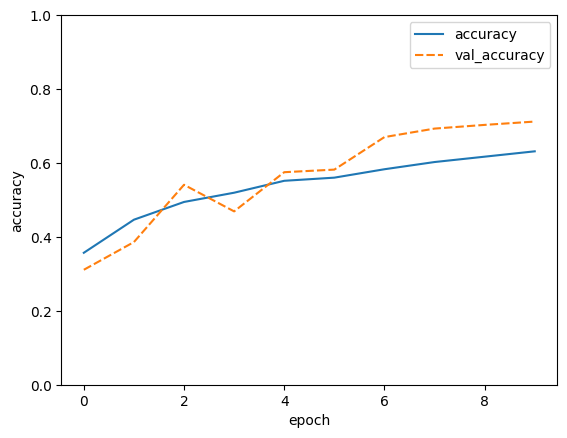

In [17]:
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})
ax.set(xlabel='epoch', ylabel='accuracy', ylim=(0,1))